In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y - ответы на ней

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

Обучать будем логистическую регрессию

## Предобработка данных

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными (в случае наличия среди них категорий, их требуется некоторым способом преобразовать в вещественные числа)
- среди $X$ не должно быть пропущенных значений (т.е. все пропущенные значения перед применением модели следует каким-то образом заполнить)

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [6]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
categorical_cols

['RFCD.Code.2',
 'Home.Language.1',
 'C.1',
 'A.1',
 'Person.ID.1',
 'Dept.No..1',
 'RFCD.Code.5',
 'RFCD.Code.1',
 'Faculty.No..1',
 'No..of.Years.in.Uni.at.Time.of.Grant.1',
 'SEO.Code.2',
 'B.1',
 'RFCD.Code.4',
 'RFCD.Code.3',
 'Sponsor.Code',
 'SEO.Code.1',
 'With.PHD.1',
 'A..1',
 'SEO.Code.3',
 'SEO.Code.4',
 'Role.1',
 'SEO.Code.5',
 'Grant.Category.Code',
 'Country.of.Birth.1',
 'Contract.Value.Band...see.note.A']

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [7]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию

## Обработка пропущенных значений.
1. Заполним пропущенные вещественные значения в X нулями и средними по столбцам
2. Все категориальные признаки в X преобразуем в строки, пропущенные значения также преобразуем в какие-либо строки, которые не являются категориями (например, 'NA')

In [8]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

        
means_of_float_X = calculate_means(data[numeric_cols])

In [9]:
X_real_zeros = X[numeric_cols].copy()
X_real_mean = X[numeric_cols].copy()

for column in numeric_cols:
    X_real_zeros[column].fillna(0, inplace = True)

for column in numeric_cols:
    X_real_mean[column].fillna(means_of_float_X[column], inplace = True)

In [10]:
X_cat = X[categorical_cols].copy()
X_cat.fillna('NA', inplace = True)
X_cat = X_cat.astype(str)

## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

In [11]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

In [12]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Сравнение способов заполнения вещественных пропущенных значений.
1. Составим две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними.
2. Обучим на них логистическую регрессию, подбирая параметры из сетки param_grid по методу кросс-валидации с числом фолдов cv=3. 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import grid_search, linear_model

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

# 1) Составляем обучающие выборки
train_zeros=np.hstack((X_train_real_zeros,X_train_cat_oh))
train_means=np.hstack((X_train_real_mean,X_train_cat_oh))

# 2) Обучаем на них логистическую регрессию
classifier_zeros = linear_model.LogisticRegression(random_state = 0)
classifier_means = linear_model.LogisticRegression(random_state = 0)

grid_cv_means = grid_search.GridSearchCV(classifier_means, param_grid, cv = cv)
grid_cv_zeros = grid_search.GridSearchCV(classifier_zeros, param_grid, cv = cv)

grid_cv_means.fit(train_means, y_train)
grid_cv_zeros.fit(train_zeros, y_train)

test_zeros=np.hstack((X_test_real_zeros,X_test_cat_oh))
test_means=np.hstack((X_test_real_mean,X_test_cat_oh))

predicted_zeros=grid_cv_zeros.best_estimator_.predict_proba(test_zeros)[:,1]
predicted_means=grid_cv_means.best_estimator_.predict_proba(test_means)[:,1]
roc_zeros=roc_auc_score(y_test, predicted_zeros)
roc_means=roc_auc_score(y_test, predicted_means)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


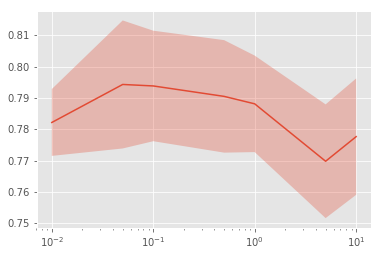

AUC ROC = 0.8854366325105085


In [34]:
plot_scores(grid_cv_means)
print("AUC ROC = {}".format(roc_means))

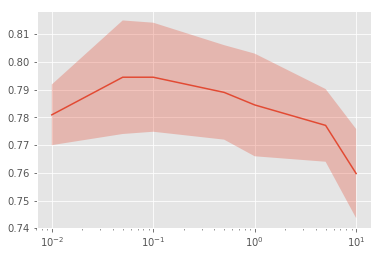

AUC ROC = 0.8841064355547416


In [33]:
plot_scores(grid_cv_zeros)
print("AUC ROC = {}".format(roc_zeros))

## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


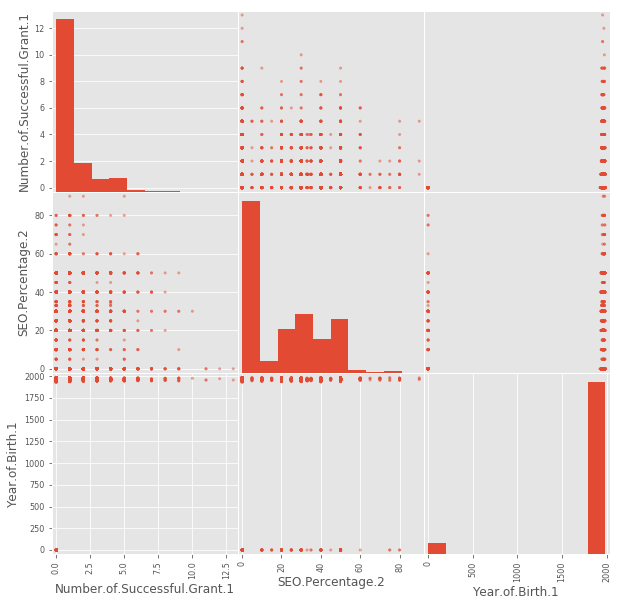

In [16]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений. В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
scaler_train.fit(X_train_real_zeros, y_train)


X_train_real_scaled=scaler_train.transform(X_train_real_zeros)
X_test_real_scaled=scaler_train.transform(X_test_real_zeros)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


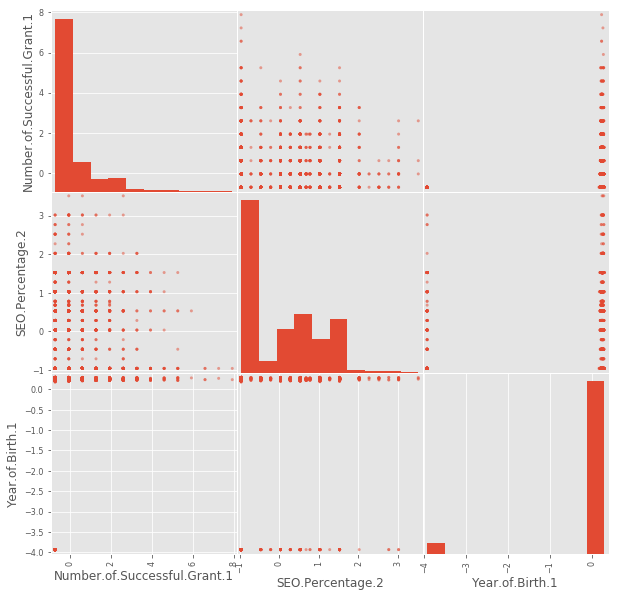

In [18]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Сравнение качества классификации до и после масштабирования вещественных признаков.

In [19]:
learn_zeros_scaled=np.hstack((X_train_real_scaled,X_train_cat_oh))
test_zeros_scaled=np.hstack((X_test_real_scaled,X_test_cat_oh))

classifier_zeros_scaled = linear_model.LogisticRegression(random_state = 0)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

grid_cv_zeros_scaled = grid_search.GridSearchCV(classifier_zeros_scaled, param_grid, cv = cv)
grid_cv_zeros_scaled.fit(learn_zeros_scaled, y_train)

predicted_zeros_scaled=grid_cv_zeros_scaled.best_estimator_.predict_proba(test_zeros_scaled)[:,1]

roc_zeros_scaled=roc_auc_score(y_test, predicted_zeros_scaled)

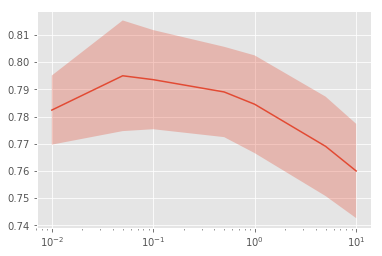

In [20]:
plot_scores(grid_cv_zeros_scaled)

In [31]:
print("AUC ROC = {}".format(roc_zeros_scaled))

AUC ROC = 0.885044379082622


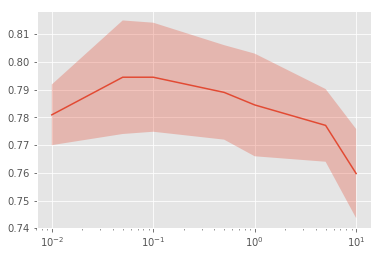

In [21]:
plot_scores(grid_cv_zeros)

In [32]:
print("AUC ROC = {}".format(roc_zeros))

AUC ROC = 0.8841064355547416


## Балансировка классов.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Рассмотрим пример с выборками, сэмплированными из двух гауссиан. Их мат. ожидания и матрицы ковариации заданы так, что истинная разделяющая поверхность должна проходить параллельно оси x. Поместим в обучающую выборку 20 объектов, сэмплированных из 1-й гауссианы, и 10 объектов из 2-й. После этого обучим на них линейную регрессию, и построим на графиках объекты и области классификации.

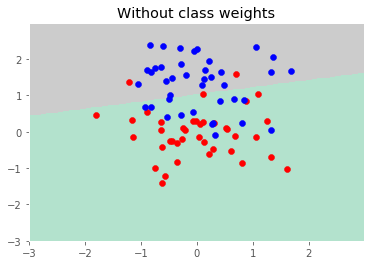

AUC: 0.906667


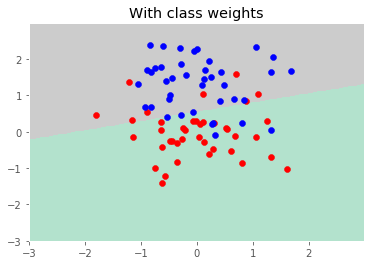

AUC: 0.895000


In [22]:
np.random.seed(0)
"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
"""И из второй"""
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)
"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])
"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])
"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
"""Строим предсказания регрессии для сетки"""
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)
"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

Как видно, во втором случае классификатор находит разделяющую поверхность, которая ближе к истинной, т.е. меньше переобучается. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [23]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами, например:
- давать объектам миноритарного класса больший вес при обучении классификатора
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

## Балансировка классов.
1. Обучим логистическую регрессию и гиперпараметры с балансировкой классов, используя веса на отмасштабированных выборках.
2. Получим метрику ROC AUC на тестовой выборке.
3. Сбалансируем выборку, досэмплировав в неё объекты из меньшего класса.
4. Получим метрику ROC AUC на тестовой выборке, сравним с предыдущим результатом.

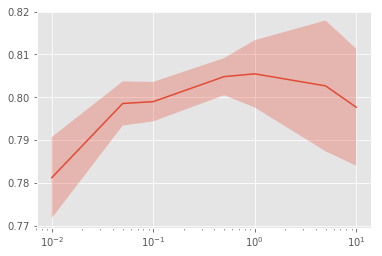

In [24]:
np.random.seed(0)
indices_to_add = np.random.randint(np.sum(y_train==1),size=(np.sum(y_train==0)-np.sum(y_train==1)))
X_train_to_add = X_train_real_scaled[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_real_scaled_samp=np.vstack((X_train_real_scaled, X_train_to_add))
y_train_to_add = y_train[y_train == 1][indices_to_add]
y_train_to_add = y_train_to_add.fillna(1)
y_train_sam = np.hstack((y_train, y_train_to_add))
X_train_cat_oh_add = X_train_cat_oh[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_cat_oh_sam = np.vstack((X_train_cat_oh, X_train_cat_oh_add))

classifier_zeros_scaled_sam = linear_model.LogisticRegression(random_state = 0)

grid_cv_zeros_scaled_sam = grid_search.GridSearchCV(classifier_zeros_scaled_sam, param_grid, cv = 3)

learn_zeros_scaled_sam = np.hstack((X_train_real_scaled_samp,X_train_cat_oh_sam))

grid_cv_zeros_scaled_sam.fit(learn_zeros_scaled_sam, y_train_sam)

predicted_zeros_scaled_sam = grid_cv_zeros_scaled_sam.best_estimator_.predict_proba(test_zeros_scaled)[:,1]

roc_zeros_scaled_sam = roc_auc_score(y_test, predicted_zeros_scaled_sam)

plot_scores(grid_cv_zeros_scaled_sam)

In [29]:
print("AUC ROC = {}".format(roc_zeros_scaled_sam))

AUC ROC = 0.8832711956057716


In [25]:
X_train_cat_oh_add.shape

(432, 5593)

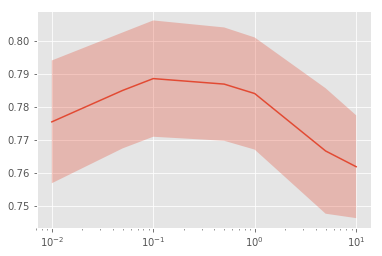

In [26]:
classifier_zeros_scaled_bal = linear_model.LogisticRegression(random_state = 0, class_weight='balanced')

grid_cv_zeros_scaled_bal = grid_search.GridSearchCV(classifier_zeros_scaled_bal, param_grid, cv = 3)

grid_cv_zeros_scaled_bal.fit(learn_zeros_scaled, y_train)

predicted_zeros_scaled_bal=grid_cv_zeros_scaled_bal.best_estimator_.predict_proba(test_zeros_scaled)[:,1]

roc_zeros_scaled_bal=roc_auc_score(y_test, predicted_zeros_scaled_bal)

plot_scores(grid_cv_zeros_scaled_bal)

In [30]:
print("AUC ROC = {}".format(roc_zeros_scaled_bal))

AUC ROC = 0.8871850681370189


## Стратификация выборок.

Рассмотрим ещё раз пример с выборками из нормальных распределений. Посмотрим ещё раз на качество классификаторов, получаемое на тестовых выборках:

In [27]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.906666666667
AUC ROC for classifier with weighted classes:  0.895


Насколько эти цифры реально отражают качество работы алгоритма, если учесть, что тестовая выборка так же несбалансирована, как обучающая? При этом мы уже знаем, что алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке, т.е. в данном случае на тесте он будет давать заведомо заниженные результаты. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну: по 20 из каждого класса на обучени и на тесте. Переформируем выборки и подсчитаем новые ошибки:

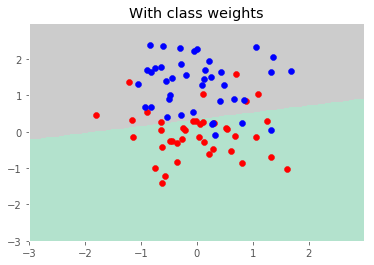

AUC ROC for stratified samples:  0.91


In [28]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])
"""Обучим классификатор"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

Как видно, после данной процедуры ответ классификатора изменился незначительно, а вот качество увеличилось. При этом, в зависимости от того, как мы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, т.к. она построена с учётом специфики работы классификатора.

1. Разобъем выборки X_real_zeros и X_cat_oh на обучение и тест, передавая в функцию 
        train_test_split(...)
   дополнительно параметр 
       stratify=y
2. Выполним масштабирование новых вещественных выборок, обучим классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов.
3. Оценим качество классификатора по метрике AUC ROC на тестовой выборке.

In [35]:
       
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0, stratify=y)
# Масштабирование выборки
scaler_train = StandardScaler()
scaler_train.fit(X_train_real_zeros, y_train)

X_train_real_scaled=scaler_train.transform(X_train_real_zeros)
X_test_real_scaled=scaler_train.transform(X_test_real_zeros)

# Обучение классификатора и его гиперпараметров при помощи метода кросс-валидации

X_train_scaled=np.hstack((X_train_real_scaled,X_train_cat_oh))
X_test_scaled=np.hstack((X_test_real_scaled,X_test_cat_oh))

classifier_scaled = linear_model.LogisticRegression(random_state = 0, class_weight='balanced')

grid_cv_classifier_scaled = grid_search.GridSearchCV(classifier_scaled, param_grid, cv = cv)

grid_cv_classifier_scaled.fit(X_train_scaled, y_train)
predicted_classifier_scaled = grid_cv_classifier_scaled.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_classifier_scaled = roc_auc_score(y_test, predicted_classifier_scaled)

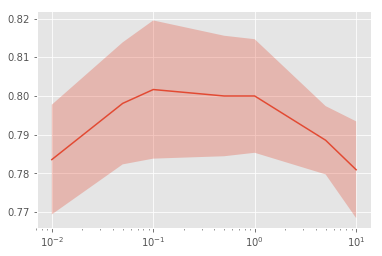

AUC ROC = 0.8793487130496221


In [36]:
plot_scores(grid_cv_classifier_scaled)
print("AUC ROC = {}".format(roc_classifier_scaled))

## Трансформация признаков.

Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков мы дополнительно включаем в набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

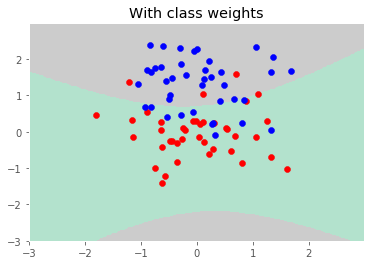

In [41]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

Видно, что данный метод преобразования данных уже позволяет строить нелинейные разделяющие поверхности, которые могут более тонко подстраиваться под данные и находить более сложные зависимости. Число признаков в новой модели:

In [42]:
print(example_data_train_poly.shape[1])

6


Но при этом одновременно данный метод способствует более сильной способности модели к переобучению из-за быстрого роста числа признаком с увеличением степени $p$. Рассмотрим пример с $p=11$:

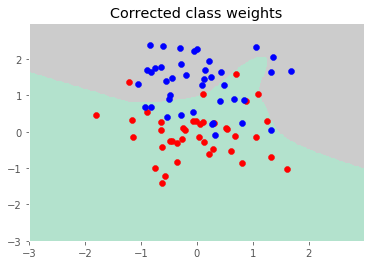

In [43]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

Количество признаков в данной модели:

In [44]:
print(example_data_train_poly.shape[1])

78


1. Реализуем преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2
2. Построим логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Для обучения будем использовать стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки заново отмасштабируем.
3. Получим AUC ROC на тесте и сравним данный результат с использованием обычных признаков.

In [45]:
transform = PolynomialFeatures(2)

X_train_zeros_poly = transform.fit_transform(X_train_real_zeros)
X_test_zeros_poly = transform.transform(X_test_real_zeros)

scaler_train = StandardScaler()
scaler_train.fit(X_train_zeros_poly, y_train)

X_train_zeros_poly_scaled=scaler_train.transform(X_train_zeros_poly)
X_test_zeros_poly_scaled=scaler_train.transform(X_test_zeros_poly)

X_train_poly = np.hstack((X_train_zeros_poly_scaled, X_train_cat_oh))
X_test_poly = np.hstack((X_test_zeros_poly_scaled, X_test_cat_oh))

classifier_poly = linear_model.LogisticRegression(random_state = 0, class_weight='balanced', fit_intercept=False)

grid_cv_classifier_poly = grid_search.GridSearchCV(classifier_poly, param_grid, cv = cv)

grid_cv_classifier_poly.fit(X_train_poly, y_train)
predicted_classifier_poly = grid_cv_classifier_poly.best_estimator_.predict_proba(X_test_poly)[:,1]

roc_classifier_poly = roc_auc_score(y_test, predicted_classifier_poly)

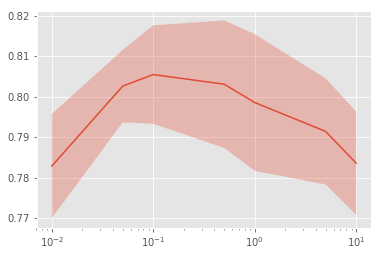

AUC ROC = 0.8869913025739007


In [48]:
plot_scores(grid_cv_classifier_poly)
print("AUC ROC = {}".format(roc_classifier_poly))

## Регрессия Lasso.
К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков.

1. Обучим регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получим ROC AUC регрессии, сравним его с предыдущими результатами.
3. Найдем номера вещественных признаков, которые имеют нулевые веса в итоговой модели.

In [47]:
classifier_scaled_lasso = linear_model.LogisticRegression(random_state = 0, class_weight='balanced', penalty='l1')
grid_cv_classifier_scaled_lasso = grid_search.GridSearchCV(classifier_scaled_lasso, param_grid, cv = cv)

grid_cv_classifier_scaled_lasso.fit(X_train_scaled, y_train)
predicted_classifier_scaled_lasso = grid_cv_classifier_scaled_lasso.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_classifier_scaled_lasso = roc_auc_score(y_test, predicted_classifier_scaled_lasso)

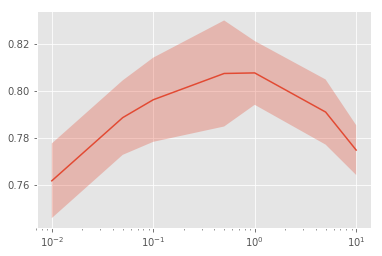

AUC ROC = 0.8765324984202327


In [49]:
plot_scores(grid_cv_classifier_scaled_lasso)
print("AUC ROC = {}".format(roc_classifier_scaled_lasso))

In [55]:
grid_cv_classifier_scaled_lasso.best_estimator_.coef_[0][4]

0.0

In [57]:
for i in grid_cv_classifier_scaled_lasso.best_estimator_.coef_:
    lst_x = list(i[:13])

In [58]:
n = -1
lst_coef = []
for i in lst_x:
    n += 1
    if i == 0:
        lst_coef.append(n)

In [59]:
lst_coef

[4, 6, 7]